In [1]:
import requests
r = requests.get("https://www.emerald.com/insight/sitemap/publications")

In [3]:
import re
publications = re.findall(r'<a href="/insight/publication.*</a>', r.text)

In [26]:
urls = ['https://www.emerald.com' + i[9:44] for i in publications]

urls = urls[:urls.index('https://www.emerald.com/insight/publication/acronym/ASEEE"')]
len(urls)

In [16]:
htmls = {}

In [27]:
import time
import random
from tqdm import tqdm

for u in tqdm(urls):
    if u in htmls:
        continue
    r = requests.get(u)
    if r.ok:
        htmls[u] = r.text
    else:
        print(u)
    time.sleep(random.random() * 0.7)


100%|██████████| 484/484 [00:00<00:00, 748265.07it/s]


In [28]:
len(urls),len(htmls)

(484, 649)

In [61]:
import pickle
with open('journal_main_page_html.pkl', 'wb') as f:
    pickle.dump(htmls, f)

In [68]:
import bs4

soup = bs4.BeautifulSoup(tmp)

def name_and_cat(t):
    soup = bs4.BeautifulSoup(t)
    breadcrumbs = soup.find('breadcrumbs')
    jour_name = [i[0] for i in eval(breadcrumbs.attrs['crumbs'])][-1]
    
    for h2 in soup.find_all('h2'):
        if 'Category:' in h2.text:
            return jour_name, h2.find_next_sibling().text
    return jour_name, None

cat_tuple = [name_and_cat(htmls[i]) for i in htmls]

cat_dict = dict(cat_tuple)

In [84]:
with open('journal_to_category.pkl', 'wb') as f:
    pickle.dump(cat_dict, f)

In [71]:
def abstract_length(j):
    abstract_sections_names = j['abstract_sections_names']
    abstract_sections = j['abstract_sections']

    section_length = {}
    for title, sec in zip(abstract_sections_names, abstract_sections):
        if title not in ('Purpose', 'Design/methodology/approach', 'Findings', 'Originality/value'):
            continue
        text = ' '.join(par for par in sec)
        section_length[title] = len(text.split())

    return sum([section_length[i] for i in ('Purpose', 'Design/methodology/approach', 'Findings', 'Originality/value')])

## Add category info to jsonl; filter out lines with too short/long abstract

In [82]:
import json
out = open('/home/ubuntu/efs/emerald/emerald_with_structured_abstr_add_cat.jsonl', 'w', encoding='utf8')

count_skip = 0
with open('/home/ubuntu/efs/emerald/emerald_with_structured_abstr.jsonl') as f:
    for line in f:
        j = json.loads(line.strip())
        ab_len = abstract_length(j)
        if ab_len < 50 or ab_len > 500:
            count_skip += 1
            continue
        if not j['journal']:
            # journal name missing because of web page problems
            # I need to manually search for the journal names here
            input_name = input(f"journal name is missing for [{j['title']}]>>>")
            j['journal'] = input_name
        j['category'] = cat_dict[j['journal']]
        out.write(json.dumps(j) + '\n')

print(f"{count_skip} skip because it is too long or too short.")

journal name is missing for [Perceptions of robotics emulation of human ethics in educational settings: a content analysis]>>> Journal of Research in Innovative Teaching & Learning
journal name is missing for [Data competence maturity: developing data-driven decision making]>>> Journal of Research in Innovative Teaching & Learning
journal name is missing for [Empowerment through a teacher leadership academy]>>> Journal of Research in Innovative Teaching & Learning
journal name is missing for [Compassionate education from preschool to graduate school: Bringing a culture of compassion into the classroom]>>> Journal of Research in Innovative Teaching & Learning
journal name is missing for [Small data as a conversation starter for learning analytics: Exam results dashboard for first-year students in higher education]>>> Journal of Research in Innovative Teaching & Learning
journal name is missing for [Evaluating emotion visualizations using AffectVis, an affect-aware dashboard for students

122 skip because it is too long or too short.


In [85]:
from pprint import pprint
with open('/home/ubuntu/efs/emerald/emerald_with_structured_abstr_add_cat.jsonl') as f:
    for line in f:
        j = json.loads(line.strip())
        print(j.keys())
        pprint(j)
        break

dict_keys(['title', 'keywords', 'section_names', 'sections', 'abstract_sections_names', 'abstract_sections', 'references', 'appendix', 'journal', 'id', 'category'])
{'abstract_sections': [['The purpose of this paper is to assess ways in which '
                        'informality can be understood and reviews an emerging '
                        'area of management scholarship. The origins and '
                        'nature of informality are discussed with the aid of '
                        'two different theoretical tools: "workplace '
                        'sociology" (WS) and "mixed embeddedness" (ME).'],
                       ['The analysis is grounded in empirical material '
                        'reflecting different aspects of informality mainly '
                        'within the ethnic economy, such as a study on the '
                        'implementation of the National Minimum Wage '
                        'regulations (Ram et al., 2007; Jones et al., 2004

### Count categories

In [15]:
import json
import pandas as pd
import numpy as np
import seaborn

In [9]:
examples = []
keys = ['id', 'journal', 'category']
with open('/home/ubuntu/efs/emerald/emerald_with_structured_abstr_add_cat.jsonl') as f:
    for line in f:
        ex = json.loads(line.strip())
        examples.append({k:ex[k] for k in keys})
print(len(examples))

60024


In [11]:
ex_df = pd.DataFrame.from_records(examples, columns=keys)

In [12]:
ex_df.shape

(60024, 3)

In [19]:
print(len(ex_df['category'].unique()))
print(pd.value_counts(ex_df['category']))

25
Marketing                                  7508
Human Resource Management                  5339
Information and Knowledge Management       5287
Industry and Public Sector Management      4948
Education                                  3900
Managing Quality                           3582
Economics                                  3122
Learning and Development                   2871
Operations and Logistics Management        2787
Library and Information Science            2723
Built Environment                          2194
Health Care Management / Healthcare        2060
Accounting and Finance                     1915
Enterprise and Innovation                  1887
Tourism and Hospitality                    1603
Organization Studies                       1583
Strategy                                   1493
Business Ethics and Law                    1271
International Business                      932
Performance Management and Measurement      835
Environmental Management / Environmen

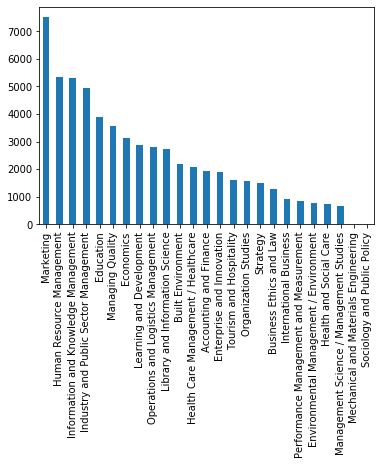

In [17]:
pd.value_counts(ex_df['category']).plot.bar()